In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

MAX_EVENT_DISPLAY = 15 # custom number of neighbors to display
TEAM_NODE_A = 1740 # home team node to focus on and see neighbors of
TEAM_NODE_B = 1455 # away team node to focus on and see neighbors of
FIG_SIZE = 10 # graph display size

/tmp/ipykernel_1441/3650957937.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
df = pd.read_csv('data/processed/lol/events.csv')

In [ ]:
focusNodes = [
    {
        'name': TEAM_NODE_A,
        'nodeList': [],
        'edgeList': []
    },
    {
        'name': TEAM_NODE_B,
        'nodeList': [],
        'edgeList': []
    }
]

nodeLabelMapper = {
    1: 'Team: \n',
    2: 'Player: \n'
}

edgeLabelMapper = {
    1: 'Won',
    2: 'Lost',
    3: 'Joined',
    4: 'Info'
}


for focusNode in focusNodes:
    selectedTeam = df.loc[df['u'] == focusNode['name'], ['u', 'v', 'u_type', 'v_type', 'e_type']].head(MAX_EVENT_DISPLAY)
    teamTypeDF = selectedTeam.drop_duplicates()
    us = list(teamTypeDF[['u', 'u_type']].itertuples(index=False, name=None))
    vs = list(teamTypeDF[['v', 'v_type']].itertuples(index=False, name=None))
    nodesList = list(list(dict.fromkeys(us + vs)))
    nodesList = list(map(lambda x: (x[0], {
        'type': x[1],
        'label': nodeLabelMapper[x[1]] + str(x[0])
        }), nodesList))
    edgesWithDups = selectedTeam.groupby(selectedTeam.columns.tolist(), as_index=False).size()
    edgesWithDupsList = list(edgesWithDups[['u', 'v', 'e_type', 'size']].itertuples(index=False, name=None))
    # Change arrow display direction if edge type is 3 (to show player joining team):
    edgesWithDupsList = list(map(lambda x: (x[1] if x[2] == 3 else x[0], x[0] if x[2] == 3 else x[1], { 
        'edge_type': x[2], 
        'weight': x[3],
        'label': edgeLabelMapper[x[2]]
        }), edgesWithDupsList))
    focusNode['nodeList'] = nodesList
    focusNode['edgeList'] = edgesWithDupsList
    print('============')
    print(focusNode['name'])
    print(focusNode['nodeList'])
    for edgeMe in focusNode['edgeList']:
        if (edgeMe[0] in [1740, 1455] and edgeMe[1] in [1740, 1455]):
            print(edgeMe)

1740
[(1740, {'type': 1, 'label': 'Team: \n1740'}), (2627, {'type': 2, 'label': 'Player: \n2627'}), (5002, {'type': 2, 'label': 'Player: \n5002'}), (6746, {'type': 2, 'label': 'Player: \n6746'}), (9932, {'type': 2, 'label': 'Player: \n9932'}), (3493, {'type': 2, 'label': 'Player: \n3493'}), (1455, {'type': 1, 'label': 'Team: \n1455'})]
(1740, 1455, {'edge_type': 1, 'weight': 1, 'label': 'Won'})
(1740, 1455, {'edge_type': 4, 'weight': 1, 'label': 'Info'})
1455
[(1455, {'type': 1, 'label': 'Team: \n1455'}), (9252, {'type': 2, 'label': 'Player: \n9252'}), (2572, {'type': 2, 'label': 'Player: \n2572'}), (4850, {'type': 2, 'label': 'Player: \n4850'}), (10240, {'type': 2, 'label': 'Player: \n10240'}), (5179, {'type': 2, 'label': 'Player: \n5179'}), (7240, {'type': 2, 'label': 'Player: \n7240'}), (6830, {'type': 2, 'label': 'Player: \n6830'}), (10080, {'type': 2, 'label': 'Player: \n10080'}), (4600, {'type': 2, 'label': 'Player: \n4600'}), (9362, {'type': 2, 'label': 'Player: \n9362'}), (1627

findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not found.
findfont: Font family 'Tahoma' not

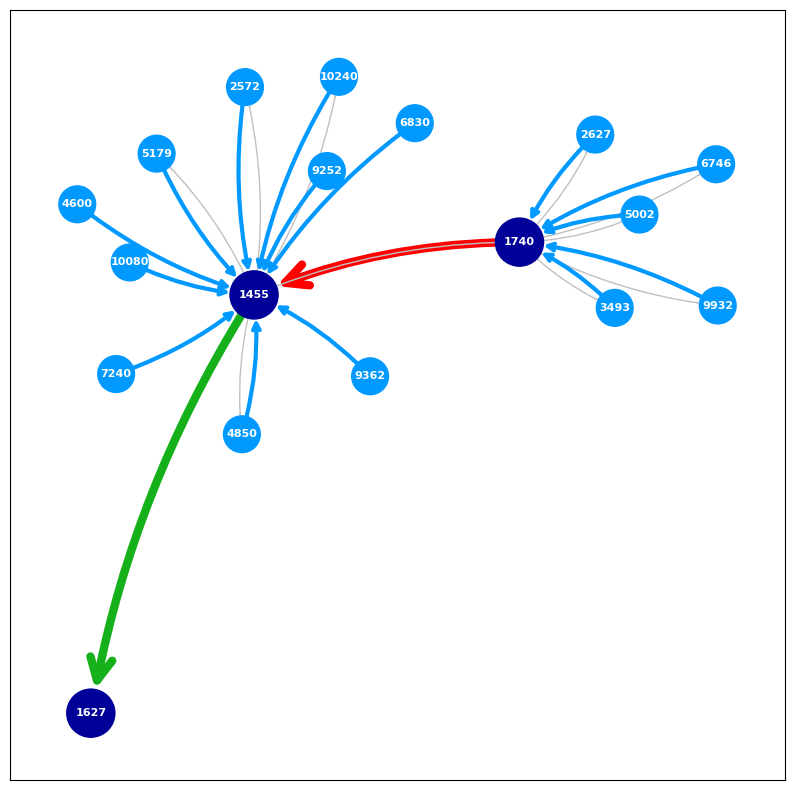

In [ ]:
focusGraph = nx.MultiDiGraph()

# Keys the same as node type
# (1) team
# (2) player
nodeSizeMapper = {
    1: 1200,
    2: 700
}

nodeColorMapper = {
    1: '#000099',
    2: '#0099FF'
}

# Keys the same as edge_type
# (1) Lost
# (2) Won
# (3) Played
# (4) Game info
edgeColorMapper = {
    1: '#FF0000',
    2: '#15B01A',
    3: '#0099FF',
    4: '#C0C0C0'
}

lineWidthMapper = {
    1: 6,
    2: 6,
    3: 3,
    4: 1
}

arrowSizeMapper = {
    1: 40,
    2: 40,
    3: 12,
    4: 1
}

allNodesList = focusNodes[0]['nodeList'] + focusNodes[1]['nodeList']
allEdgesList = focusNodes[0]['edgeList'] + focusNodes[1]['edgeList']

focusGraph.add_nodes_from(allNodesList)
focusGraph.add_edges_from(allEdgesList)

options = {
    'arrowstyle': '->',
    'arrowsize': list(arrowSizeMapper[edge_type] for u, v, edge_type in list(focusGraph.edges(data='edge_type')))
}

fig = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
pos = nx.spring_layout(focusGraph)

nx.draw_networkx(
    focusGraph,
    pos=pos,
    connectionstyle='arc3, rad = 0.1',
    arrows=True,
    **options,
    with_labels=True,
    node_color=list(nodeColorMapper[type] for u, type in list(focusGraph.nodes(data='type'))),
    edge_color=list(edgeColorMapper[edge_type] for u, v, edge_type in list(focusGraph.edges(data='edge_type'))),
    node_size=list(nodeSizeMapper[type] for u, type in list(focusGraph.nodes(data='type'))),
    font_color="white",
    font_size=8,
    font_family="Tahoma",
    font_weight="bold",
    width=list(lineWidthMapper[edge_type] for u, v, edge_type in list(focusGraph.edges(data='edge_type')))
)

# To add an invidual/multiple edges separately:
# nx.draw_networkx_edges(
#     focusGraph, 
#     pos, 
#     arrows=True,
#     connectionstyle='arc3, rad = 0.1',
#     edgelist=[(1455, 1740)], 
#     width=3)

# plt.margins(0.2)


plt.show()

# from pyvis.network import Network

# net = Network()

# net.add_node(1, label='Alex')
# net.add_node(2, label='Cathy')

# net.show('nodes.html', notebook=False) # do NOT remove the notebook=False

In [ ]:
from pyvis.network import Network

# net = Network(
#     directed = True,
#     select_menu = True, # Show part 1 in the plot (optional)
#     filter_menu = True, # Show part 2 in the plot (optional)
# )
# net.show_buttons() # Show part 3 in the plot (optional)
# net.from_nx(focusGraph) # Create directly from nx graph
# net.show('nodes.html', notebook=False) # do NOT remove the notebook=False

net = Network(
    '1500px', '1500px',
    directed=True
)
net.from_nx(focusGraph) # Create directly from nx graph
# net.add_node(1, label='Alex')
# net.add_node(2, label='Cathy')

net.show('test1.html', notebook=False) # do NOT remove the notebook=False

NameError: name 'focusGraph' is not defined